In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# Load EMNIST ByClass
(images_train, images_test), images_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,   # data is returned as (image, label)
    with_info=True        # gives metadata like number of classes
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.JJ6CR6_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.JJ6CR6_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


In [9]:
def convert_to_numpy(ds):
    images = []
    labels = []
    for image, label in tfds.as_numpy(ds):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Get numpy arrays
train_images, train_labels = convert_to_numpy(images_train)
test_images, test_labels = convert_to_numpy(images_test)

In [10]:
# Step 1: Normalize (0–255) → (0–1)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [11]:
# Shape of one image
print("Image shape:", train_images[0].shape)

# Total number of training and test examples
print("Training set size:", train_images.shape[0])
print("Test set size:", test_images.shape[0])

# Number of classes
num_classes = images_info.features['label'].num_classes
print("Number of classes:", num_classes)

Image shape: (28, 28, 1)
Training set size: 697932
Test set size: 116323
Number of classes: 62


In [13]:
# ensure the data type is good for training
train_labels = train_labels.astype('int32')
test_labels = test_labels.astype('int32')

In [23]:
def fully_fix_emnist_images(images):
    """
    Fixes EMNIST image orientation:
    - Removes the channel dim if present
    - Applies transpose and vertical flip (batch-wise)
    - Rotates each image -90° and flips horizontally
    - Adds channel dim back (for CNNs)
    """
    # Step 1: Remove channel dim if present
    if images.shape[-1] == 1:
        images = images.squeeze(-1)

    # Step 2: Transpose height and width
    images = np.transpose(images, (0, 2, 1))

    # Step 3: Flip vertically after transpose
    images = np.flip(images, axis=1)

    # Step 4: Rotate -90 and flip horizontally (for visual correctness)
    images = np.array([np.transpose(np.fliplr(np.rot90(img, k=1))) for img in images])

    # Step 5: Add channel back
    images = np.expand_dims(images, axis=-1)

    return images

In [24]:
train_images = fully_fix_emnist_images(train_images)
test_images = fully_fix_emnist_images(test_images)

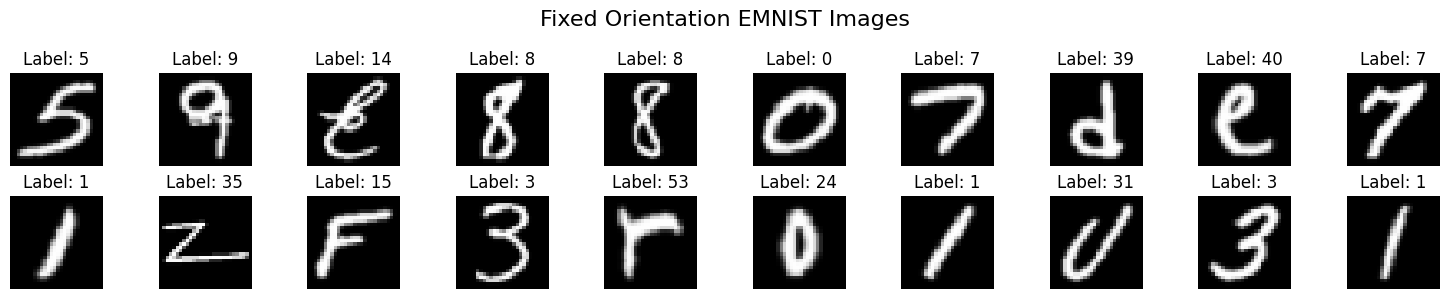

In [26]:
plt.figure(figsize=(15, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.suptitle('Fixed Orientation EMNIST Images', fontsize=16)
plt.tight_layout()
plt.show()

In [37]:
# Building The CNN Model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_emnist_resnet(input_shape=(28, 28, 1), num_classes=62):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Residual Block 1
    shortcut = x
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    # Residual Block 2 with downsampling
    shortcut = layers.Conv2D(128, 1, strides=2, padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    # Residual Block 3
    shortcut = x
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [39]:
model = build_resnet_emnist()

# Optimizer with initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │      1,664 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 14, 14,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 14, 14,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 14, 14,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 14, 14,    │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 14, 14,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 14, 14,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ activation_7[0][

 Total params: 2,796,094 (10.67 MB)

 Trainable params: 2,792,382 (10.65 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [41]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(train_images)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

In [43]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=128),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 289s 49ms/step - accuracy: 0.7901 - loss: 0.6647 - val_accuracy: 0.8572 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 2/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 300s 47ms/step - accuracy: 0.8551 - loss: 0.3993 - val_accuracy: 0.8530 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 3/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 252s 46ms/step - accuracy: 0.8625 - loss: 0.3716 - val_accuracy: 0.8384 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 4/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 252s 46ms/step - accuracy: 0.8665 - loss: 0.3595 - val_accuracy: 0.8532 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 5/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 259s 47ms/step - accuracy: 0.8691 - loss: 0.3487 - val_accuracy: 0.8571 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 6/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 259s 48ms/step - accuracy: 0.8711 - loss: 0.3424 - val_accuracy: 0.8446 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 7/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 

In [44]:
# Evaluate on test data after training
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"🔻 Test Loss: {test_loss:.4f}")

3636/3636 - 15s - 4ms/step - accuracy: 0.8619 - loss: 0.3645
✅ Test Accuracy: 86.19%
🔻 Test Loss: 0.3645


In [63]:
import tensorflow_datasets as tfds

# Load the EMNIST byclass metadata
emnist_info = tfds.builder('emnist/byclass').info
label_names = emnist_info.features['label'].int2str  # keep as is

# New helper to map to actual characters
def get_actual_char(label):
    return label_names(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


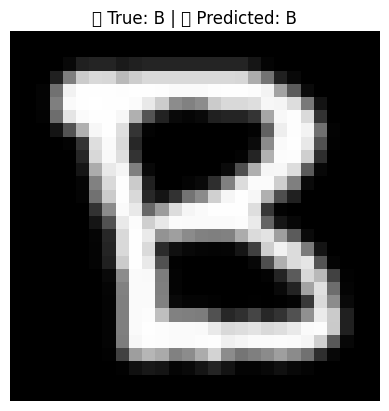

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# EMNIST byclass label to char
emnist_byclass_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z'
]

def get_actual_char(label):
    return emnist_byclass_mapping[int(label)]

# Pick a random test image
idx = np.random.randint(len(test_images))
img = test_images[idx]
true_label = test_labels[idx]

# Predict
pred = model.predict(np.expand_dims(img, axis=0))
pred_label = np.argmax(pred)

# Convert to characters
true_char = get_actual_char(true_label)
pred_char = get_actual_char(pred_label)

# Plot
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"✅ True: {true_char} | 🔮 Predicted: {pred_char}")
plt.axis('off')
plt.show()


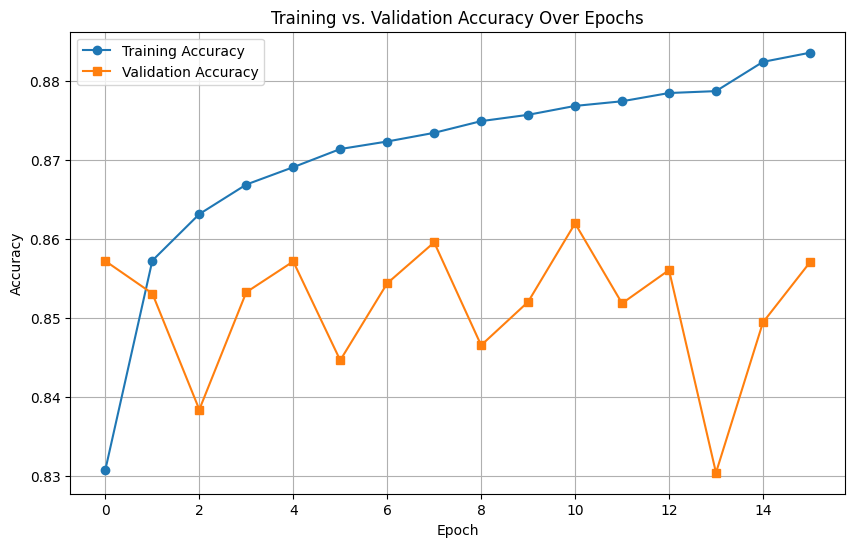

In [72]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Training vs. Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

3636/3636 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      5778
           1       0.65      0.82      0.73      6330
           2       0.98      0.95      0.97      5869
           3       1.00      0.99      1.00      5969
           4       0.99      0.96      0.98      5619
           5       0.97      0.93      0.95      5190
           6       0.99      0.96      0.98      5705
           7       0.99      0.99      0.99      6139
           8       1.00      0.98      0.99      5633
           9       0.94      0.96      0.95      5686
          10       0.96      0.99      0.98      1062
          11       0.91      0.98      0.95       648
          12       0.79      0.94      0.85      1739
          13       0.83      0.97      0.89       779
          14       0.96      0.99      0.98       851
          15       0.78      0.95      0.86      1440
          16

<ipython-input-73-49c33507da9e>:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


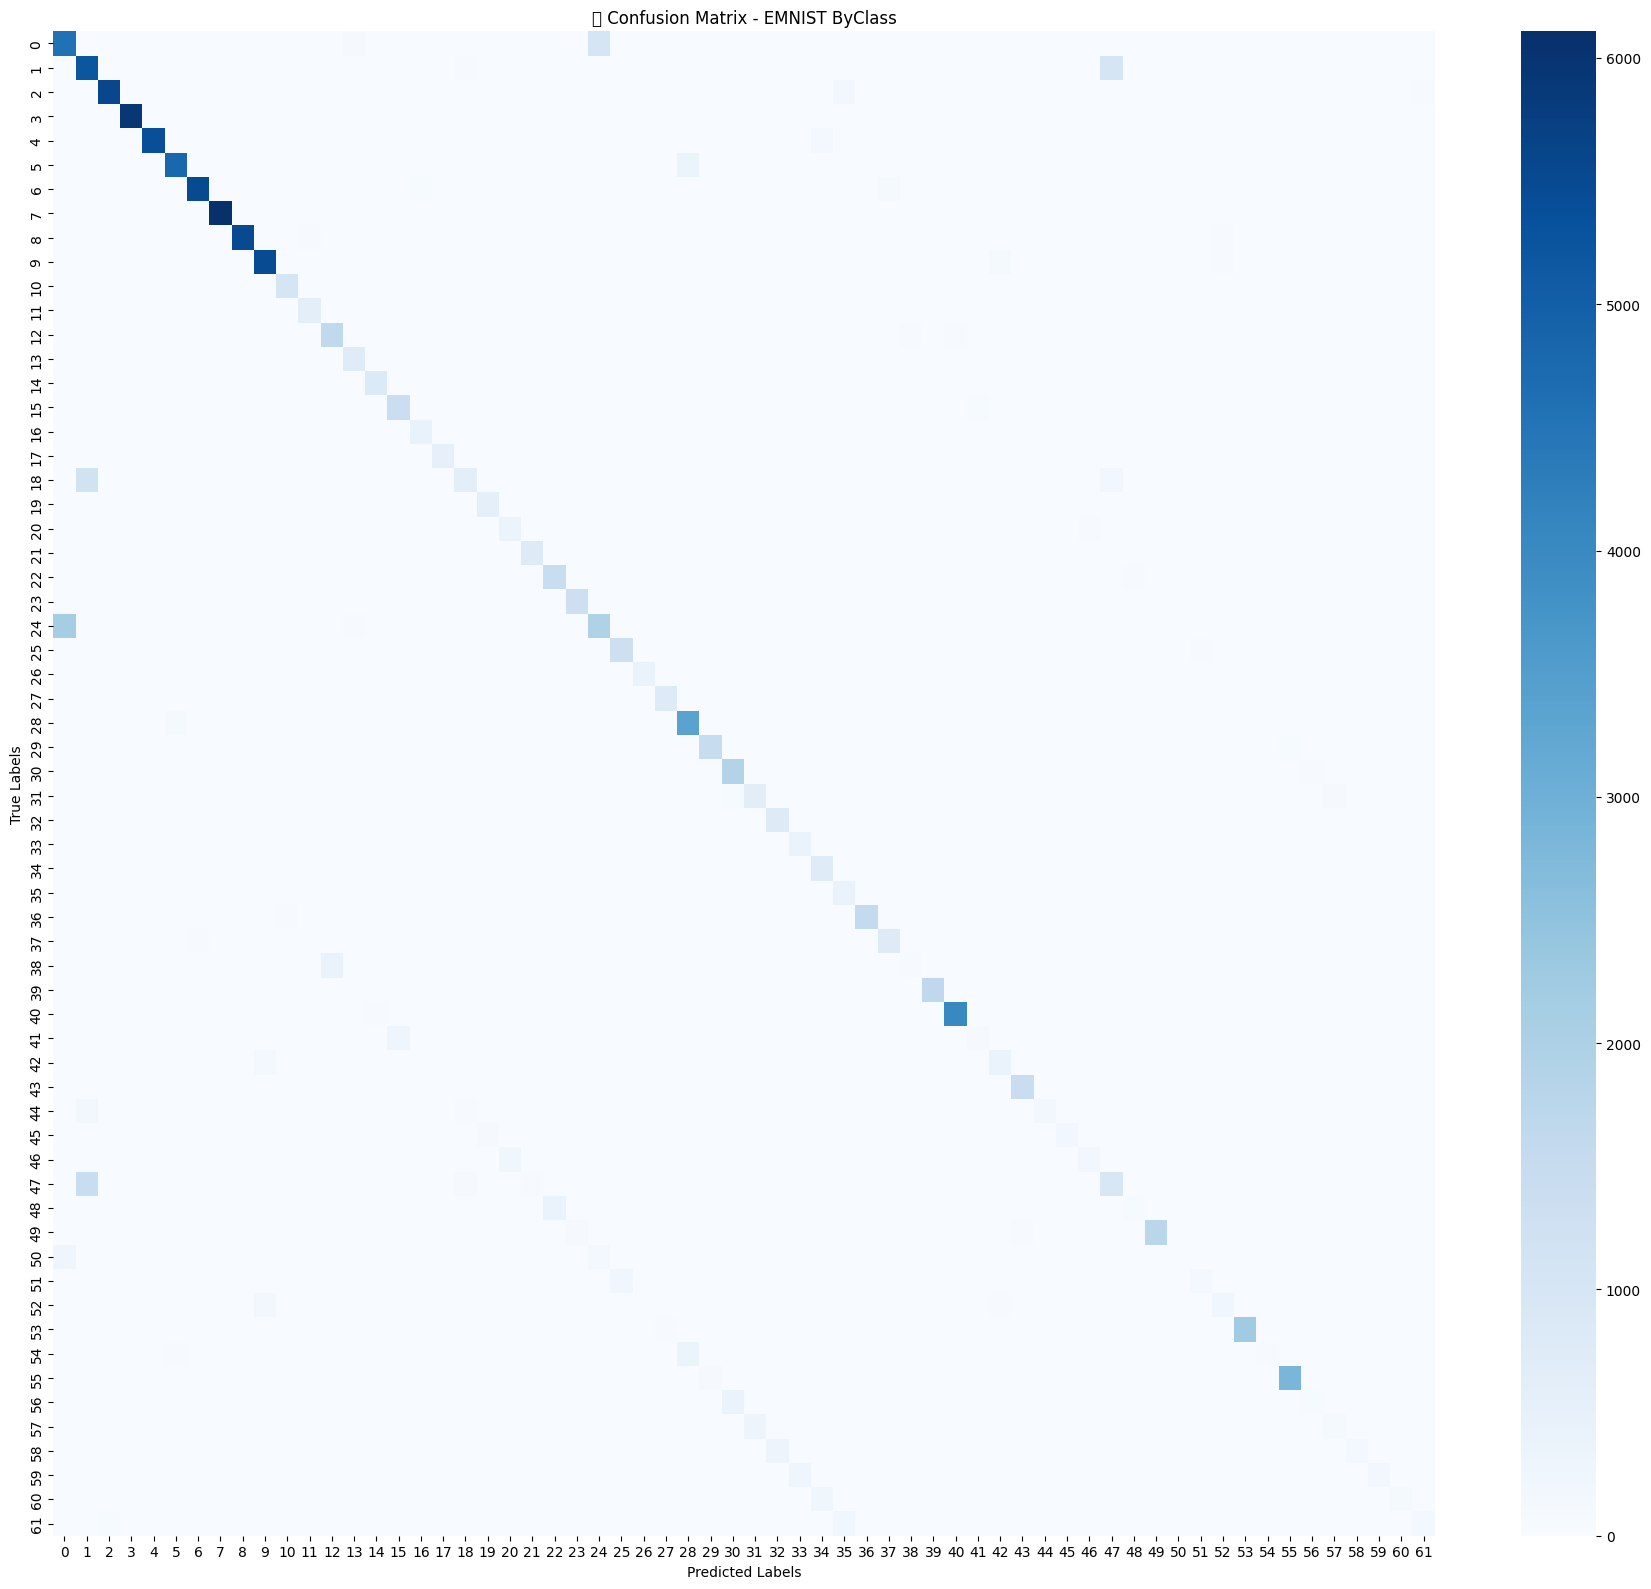

In [73]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 1. Predict labels for all test images
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

# 2. Classification report
print("🧾 Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=[tfds.builder('emnist/byclass').info.features['label'].int2str(i) for i in range(62)]))

# 3. Confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)

# 4. Plot confusion matrix
plt.figure(figsize=(18, 16))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, fmt='d')
plt.title("📉 Confusion Matrix - EMNIST ByClass")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

In [74]:
model.save("emnist_byclass_model.h5")